# Table of Contents<a name="top"></a>
- [Import Libraries and Read Data](#import)
- [Model Iteration Set 1](#set1)
    - Limits independent variables to: overall_qual, gr_liv_area, year_built, attached_garage
    - Models 1-5 
    - Submissions 4 and 5 (Submissions 1-3 low resolution sanity checks in cleaning notebook)
    - From this set of models, it appears that modeling for log y produces a better model
- [Model Iteration Set 2](#set2)
    - Input ALL variables carried over after EDA
    - Models 6-9
    - Submissions 6-9
- [Model Iteration Set 3](#set3)
    - Looking at higher coefficient variables to determine if the variables on their own should be manipulated 
    - Input smaller set of data
    - Created scatter plots of various x versus y with predicted and actual values in two different colors to look for patterns
    - Added the following variables: sqrt_gr_liv_area, log_total_bsmt_sf
    - Models 10-14 
    - Submission 10
- [Model Iteration Set 4](#set4)
    - Added interaction variables: overall_qual X residential_low, overall_qual X floating_village, sqrt_gr_liv_area X floating_village 
    - Removed low coefficient variables
    - Pulled in data previously dropped from original dataset: Fireplaces, Street type Gravel, Zoning type Commercial, Lot types IR2 and Regular -- Submission 16
    - Models 15-17
    - Submissions 11-16
- [Polynomial Fit](#set5)
    - Used poly fit to the 2nd degree to create interactions from the following variables: residential_low, overall_qual, gr_liv_area, total_bsmt_sf, floating_village
    - Based on regression coefficients, determind the two new interactions worth adding were: overall_qual^2 and overall_qual X total_bsmt_sf
    - Used this feature set to run ridge and lasso regressions
    - Models 18-20
    - Submissions 17-21
- *Modeling with sqrt y instead of log y*
    - Upon reviewing all my models and graphs, I noticed that a log fit for y may not have been the best match to the curve. 
    - I reran several of the models with sqrt y instead of loy as the dependent variable. 
    - In many cases, this slightly increased the R2 score (the biggest increase that I saw was .05, but the increase was typically more like .01-.02).
    - With more time, I would have liked to run the feature engineering using sqrt(y) as the dependent variable as I expect that this would change some results. 

<a name="import"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
h_df = pd.read_csv('./datasets/train_clean.csv')

In [4]:
kaggle_df = pd.read_csv('./datasets/test_clean.csv')

In [5]:
h_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 27 columns):
Unnamed: 0           2049 non-null int64
overall_qual         2049 non-null int64
year_built           2049 non-null int64
roof_style           2049 non-null float64
roof_matl            2049 non-null float64
mas_vnr_area         2049 non-null float64
exter_cond           2049 non-null int64
bsmt_exposure        2049 non-null float64
total_bsmt_sf        2049 non-null float64
gr_liv_area          2049 non-null int64
full_bath            2049 non-null int64
kitchen_qual         2049 non-null int64
garage_area          2049 non-null float64
paved_drive          2049 non-null int64
saleprice            2049 non-null int64
has_basement         2049 non-null int64
attached_garage      2049 non-null float64
offsite_feature      2049 non-null int64
residential_low      2049 non-null int64
residential_other    2049 non-null int64
floating_village     2049 non-null int64
hillside          

In [6]:
h_df.drop('Unnamed: 0', axis=1, inplace=True)

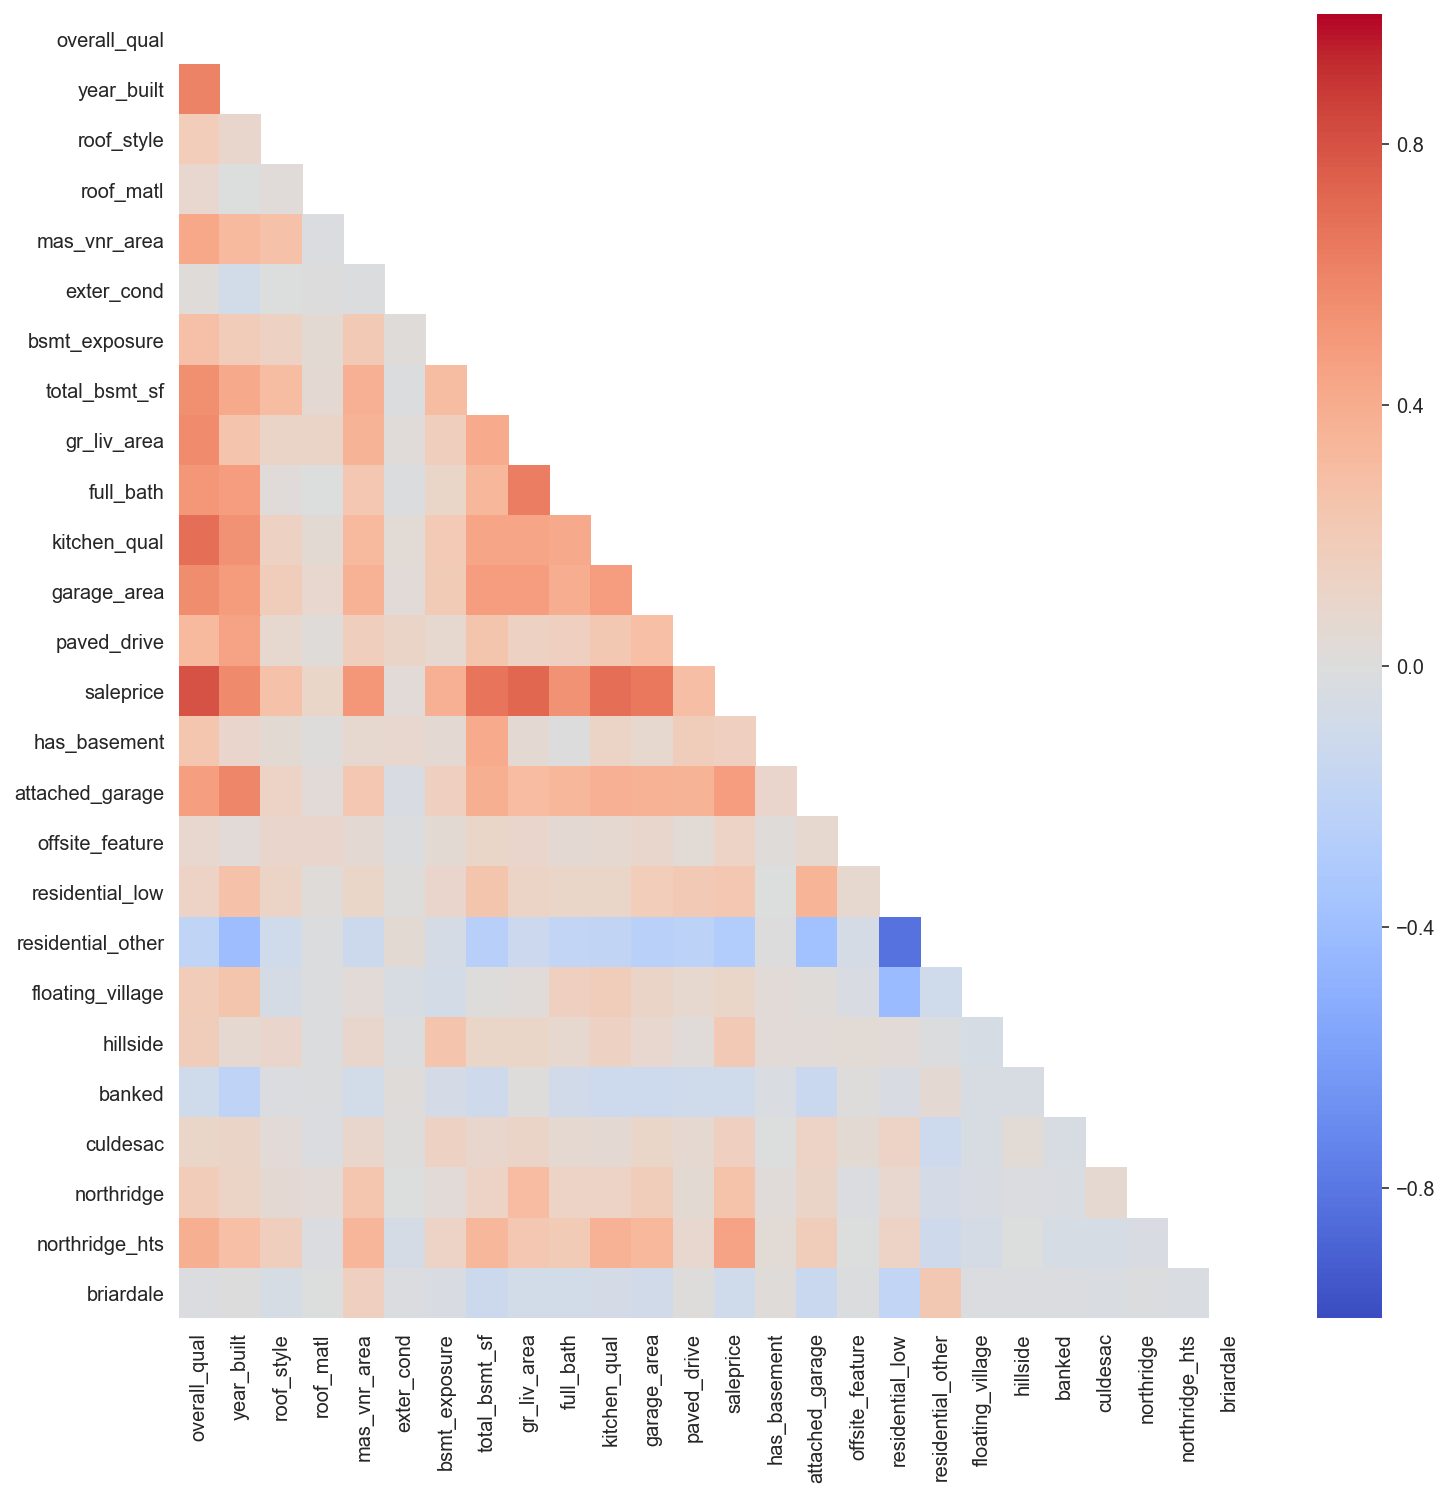

In [7]:
plt.figure(figsize=(12,12))
corr = h_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap = 'coolwarm', vmin = -1, annot=False, mask=mask);

In [8]:
corr.saleprice.sort_values()

residential_other   -0.284754
banked              -0.098756
briardale           -0.095319
exter_cond           0.036393
roof_matl            0.104329
floating_village     0.106673
offsite_feature      0.128787
has_basement         0.157410
culdesac             0.162408
hillside             0.212229
residential_low      0.231567
northridge           0.263385
roof_style           0.266010
paved_drive          0.289267
bsmt_exposure        0.379081
northridge_hts       0.448639
attached_garage      0.484028
mas_vnr_area         0.511273
full_bath            0.538225
year_built           0.572405
garage_area          0.655097
total_bsmt_sf        0.665116
kitchen_qual         0.694295
gr_liv_area          0.719463
overall_qual         0.803462
saleprice            1.000000
Name: saleprice, dtype: float64

In [9]:
# some correlation values to check: 
# High correlations not of major concern. Dummy Variables in the same category. Overall_qual vs kitchen qual

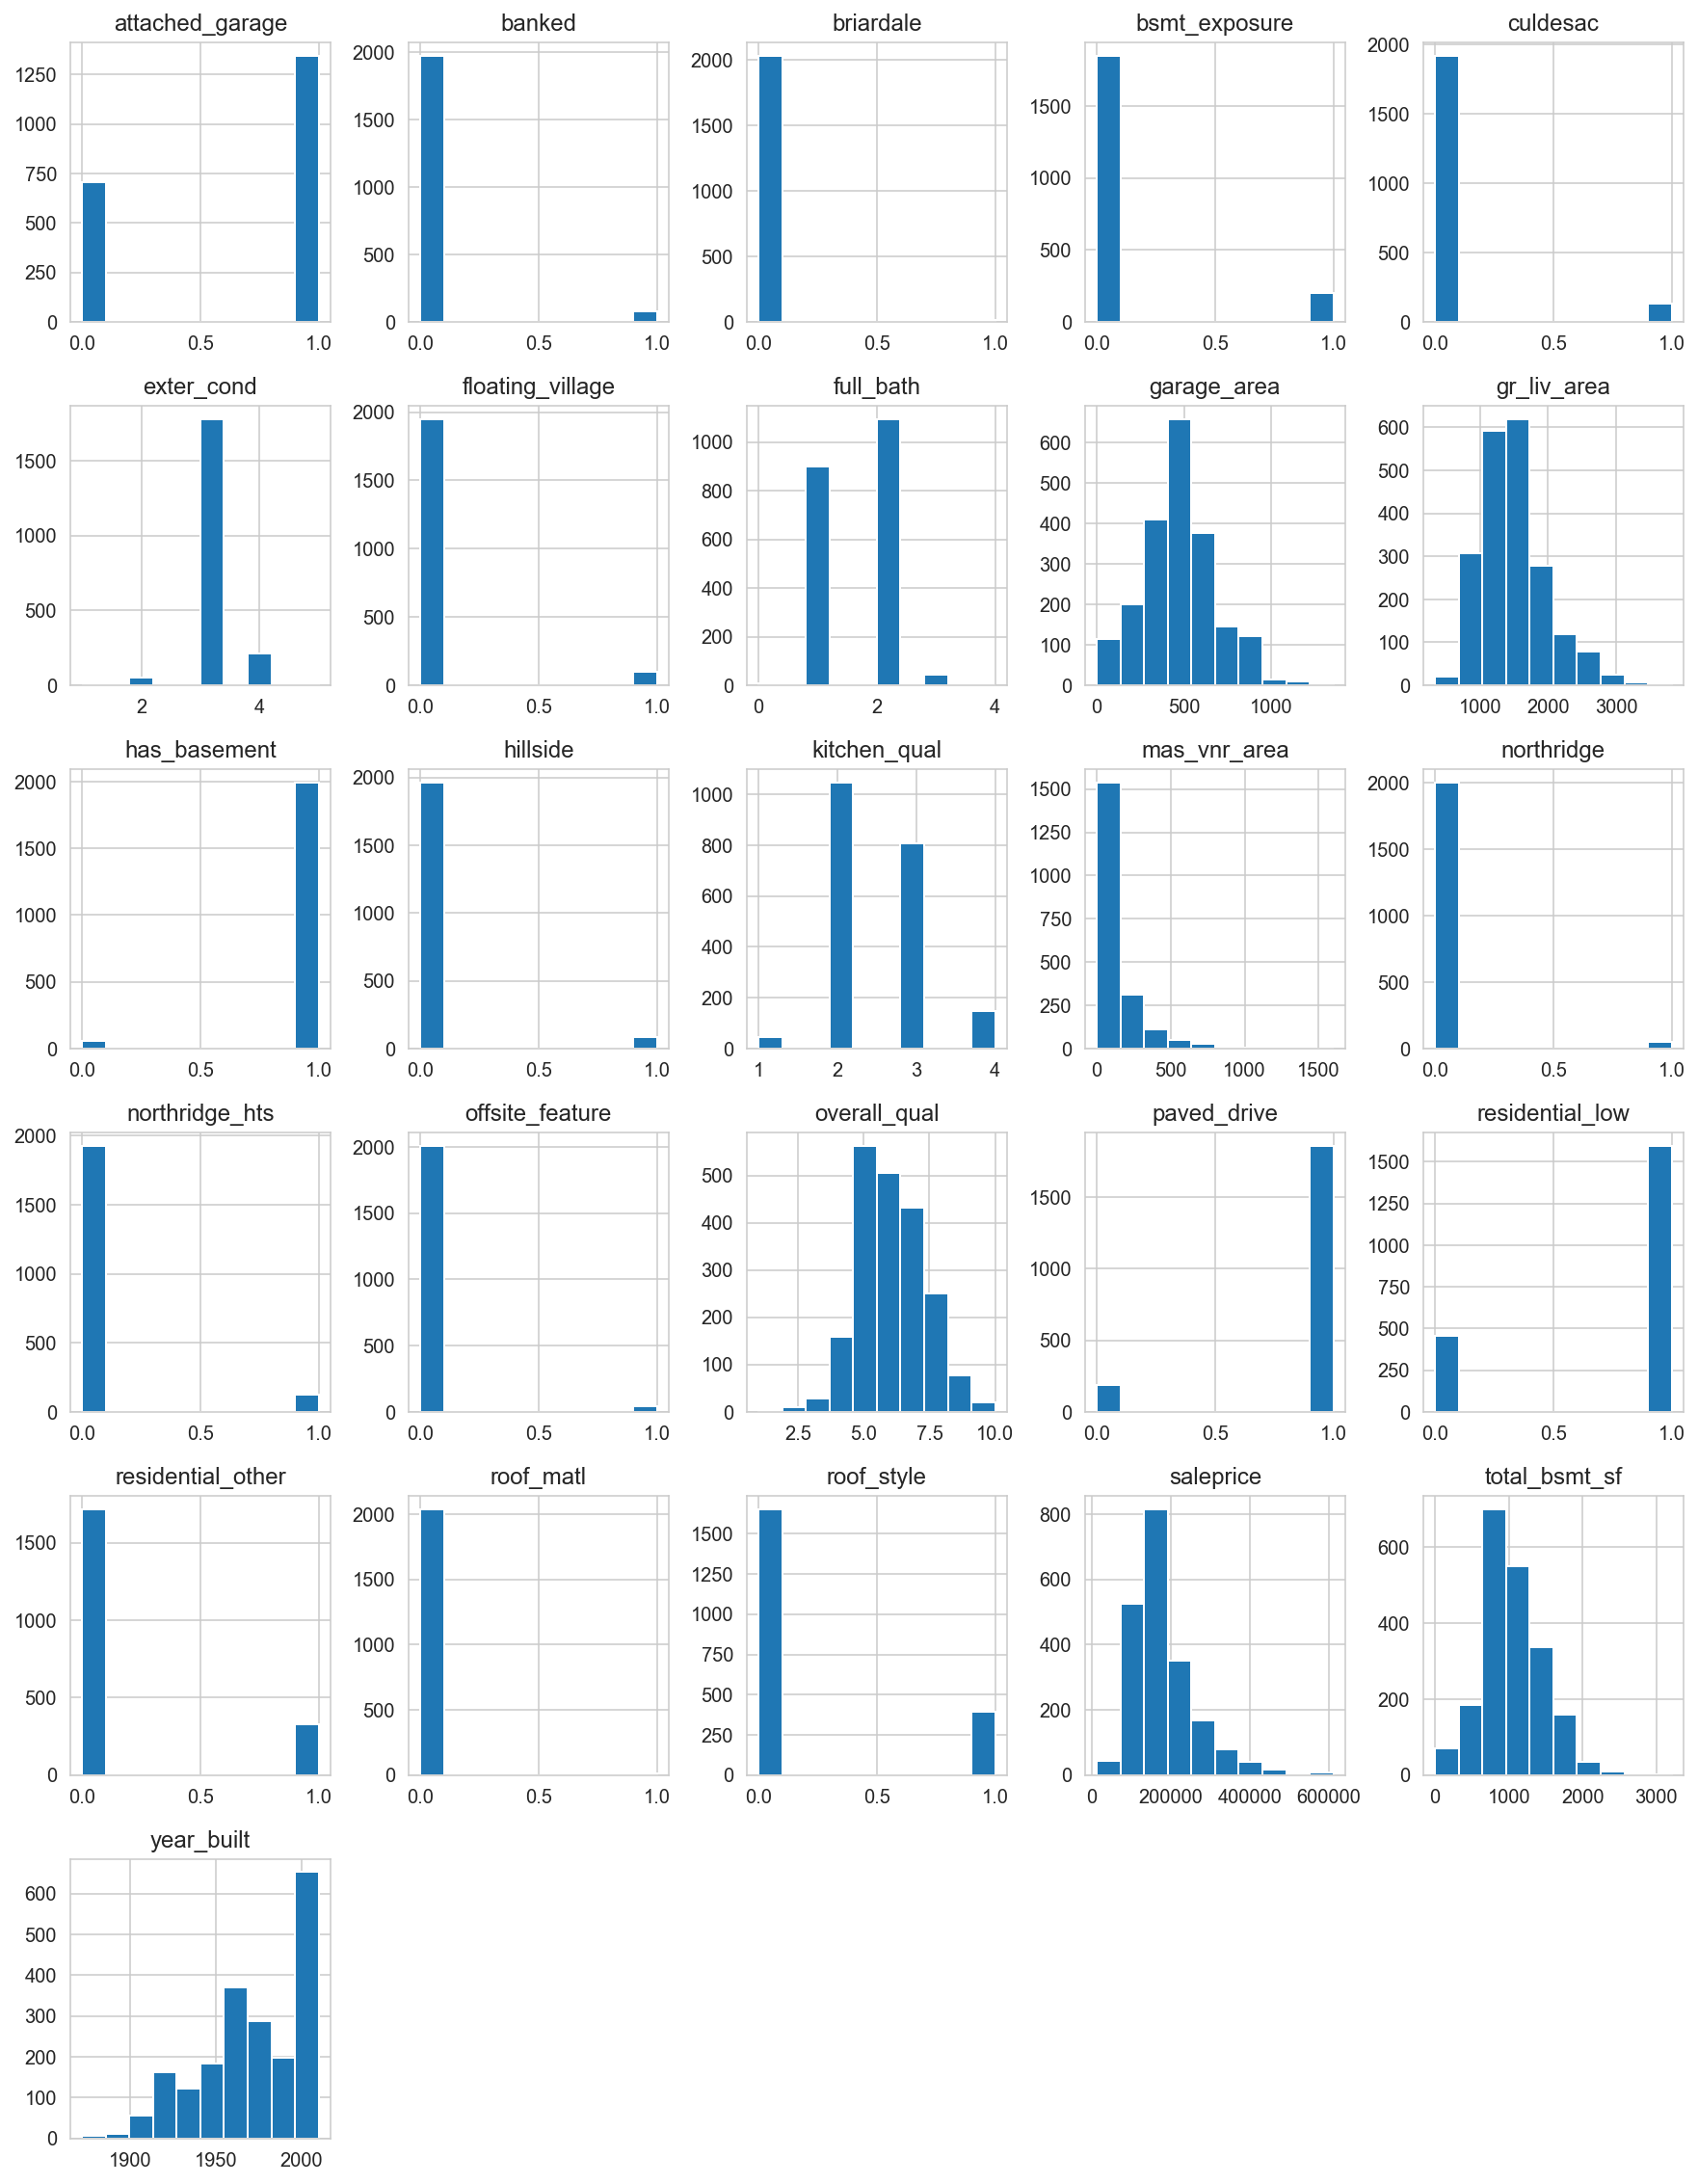

In [10]:
h_df.hist(figsize=(15,20));

## Inputs=overall_qual, gr_liv_area, year_built, attached_garage<a name="set1"></a>
1. MLR, no feature engineering
2. Log y, No change to inputs --> SUBMISSION 4
3. Log y, Log gr_liv_area, No change to other inputs 
4. Log y, Ridge regression (variables used in scenario 2) --> SUBMISSION 5
5. Log y, LASSO Regression (variables used in scenario 2)

Models are all .77-.83 R2 Scores

Ridge Model Performed Best

[back to top](#top)

In [11]:
features1 = ['overall_qual', 'gr_liv_area', 'year_built', 'attached_garage']
X1 = h_df[features1]
y1 = h_df['saleprice']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 42)

lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)

print(f'Train R2 - {lr1.score(X1_train, y1_train)}')
print(f'Test R2 - {lr1.score(X1_test, y1_test)}')
print(f'Cross Val Score - {cross_val_score(lr1, X1_train, y1_train, cv=5).mean()}')

y_pred1 = lr1.predict(X1)
resids1 = y1-y_pred1

Train R2 - 0.7758893473811805
Test R2 - 0.7650428360886569
Cross Val Score - 0.7706949800300291


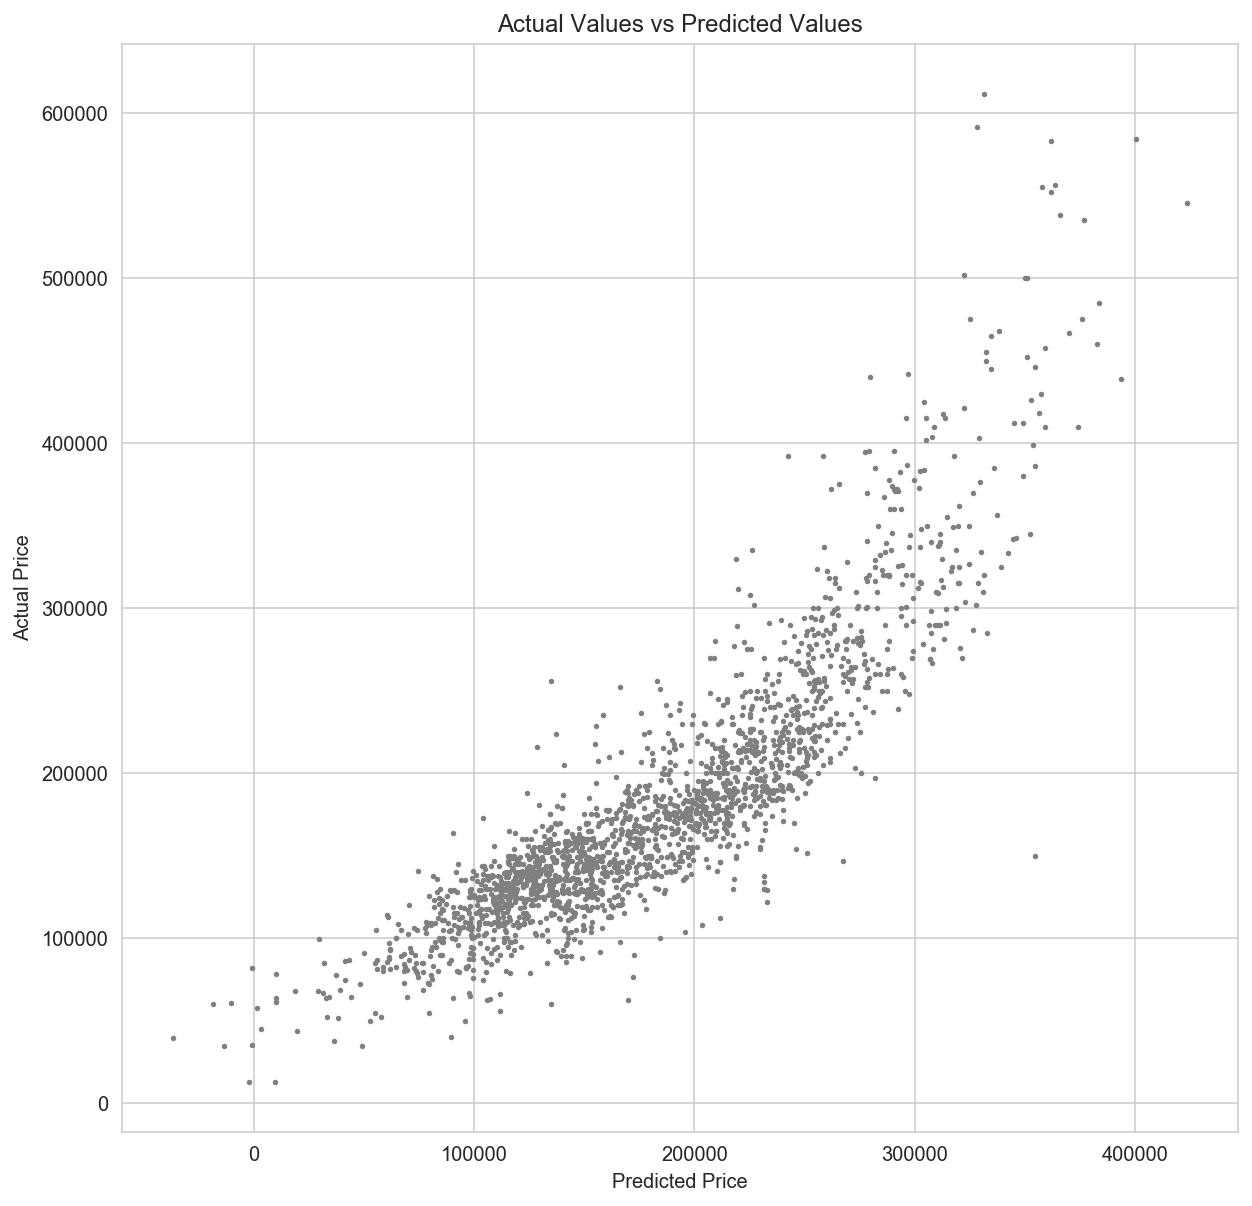

In [12]:
plt.figure(figsize = (10,10))

plt.scatter(y_pred1, y1, c='grey', s = 3)
plt.xlabel('Predicted Price')
plt.title('Actual Values vs Predicted Values')
plt.ylabel('Actual Price');

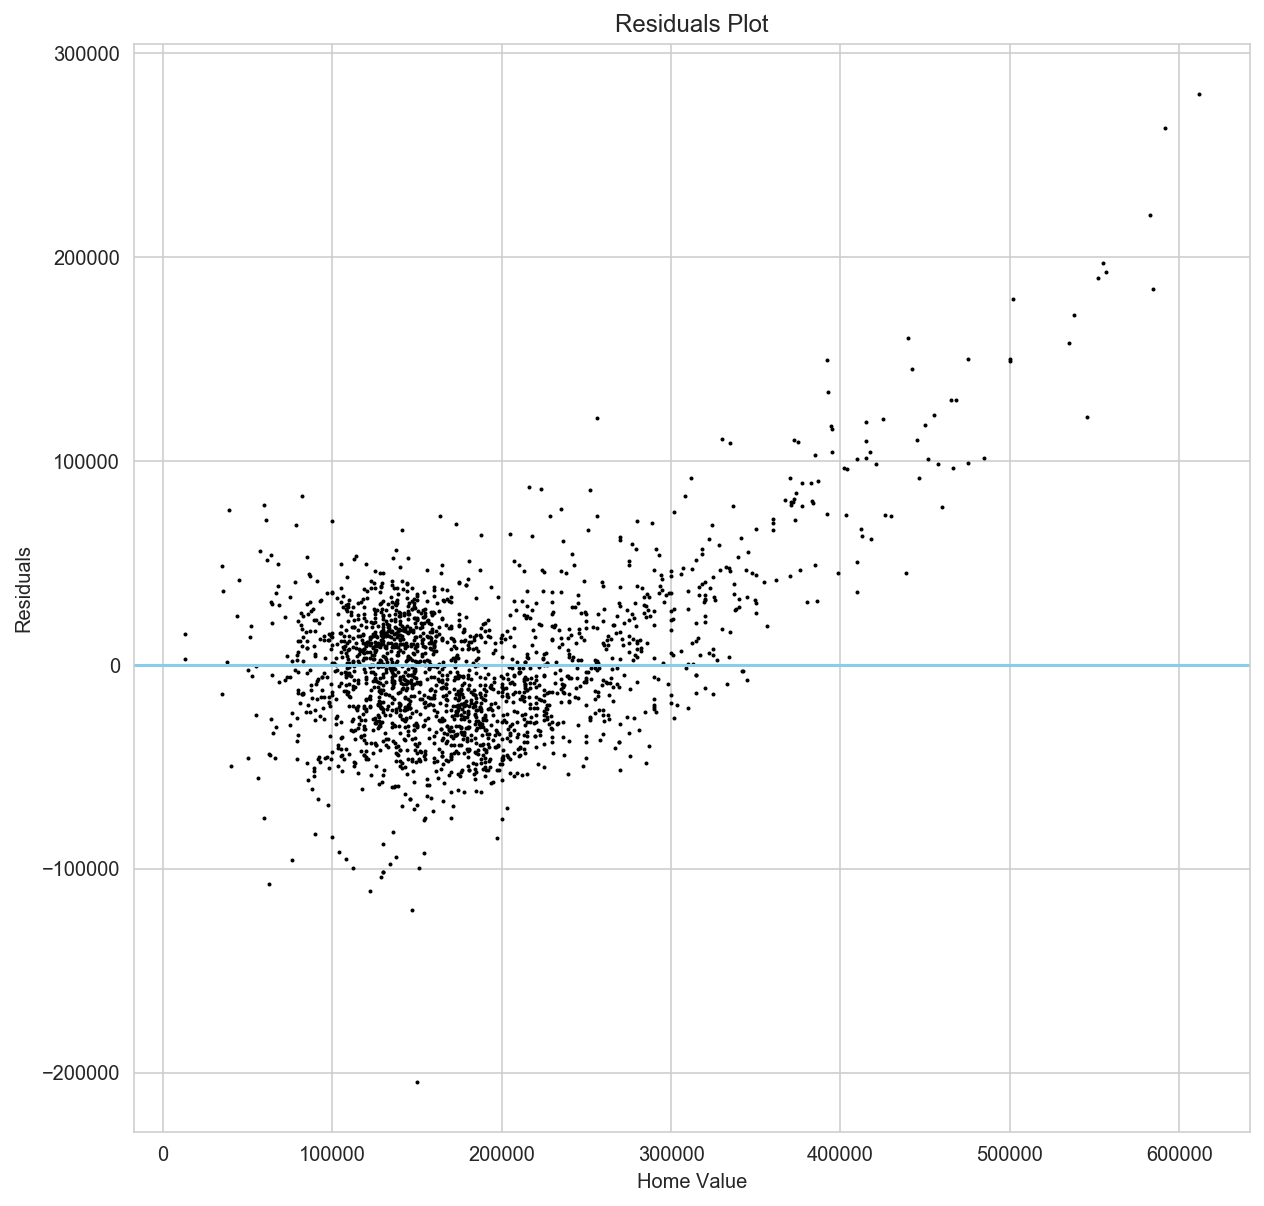

In [13]:
plt.figure(figsize = (10,10))

plt.scatter(y1, resids1, color = 'black', s=1)
plt.axhline(0, c = 'skyblue')
plt.title('Residuals Plot')
plt.xlabel('Home Value')
plt.ylabel('Residuals');

In [14]:
# plt.hist(resids1, bins=30);

In [15]:
X2 = h_df[features1]
y2 = np.log(h_df['saleprice'])

In [16]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 42)

lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)

print(f'Train R2 - {lr2.score(X2_train, y2_train)}')
print(f'Test R2 - {lr2.score(X2_test, y2_test)}')
print(f'Cross Val Score - {cross_val_score(lr2, X2_train, y2_train, cv=5).mean()}')

y_pred2 = lr2.predict(X2_train)
resids2 = np.exp(y2_train)-np.exp(y_pred2)

Train R2 - 0.8189695784391828
Test R2 - 0.7927690390750287
Cross Val Score - 0.8154584278783092


In [17]:
y_kaggle_pred2 = np.exp(lr2.predict(kaggle_df[features1]))
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=y_kaggle_pred2, columns=['SalePrice'])
y_kaggle_df['SalePrice'] = y_kaggle_pred2
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_4.csv')

In [18]:
# plt.figure(figsize = (10,10))

# plt.scatter(np.exp(y_pred2), np.exp(y2), c='grey', s = 3)
# plt.xlabel('Predicted Price')
# plt.title('Actual Values vs Predicted Values')
# plt.ylabel('Actual Price');

In [19]:
# plt.figure(figsize = (10,10))

# plt.scatter(np.exp(y2), resids2, color = 'black', s=1)
# plt.axhline(0, c = 'skyblue')
# plt.title('Residuals Plot')
# plt.xlabel('Home Value')
# plt.ylabel('Residuals');

In [20]:
# plt.hist(resids2, bins=30);

In [21]:
h_df['log_gr_liv_area'] = np.log(h_df['gr_liv_area'])
kaggle_df['log_gr_liv_area'] = np.log(kaggle_df['gr_liv_area'])
features3 = ['overall_qual', 'log_gr_liv_area', 'year_built', 'attached_garage']
X3 = h_df[features3]
y3 = np.log(h_df['saleprice'])

In [22]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state = 42)

lr3 = LinearRegression()
lr3.fit(X3_train, y3_train)

print(f'Train R2 - {lr3.score(X3_train, y3_train)}')
print(f'Test R2 - {lr3.score(X3_test, y3_test)}')
print(f'Cross Val Score - {cross_val_score(lr3, X3_train, y3_train, cv=5).mean()}')

y_pred3 = lr3.predict(X3)
resids3 = np.exp(y3)-np.exp(y_pred3)

Train R2 - 0.8175071826286774
Test R2 - 0.7852959413002906
Cross Val Score - 0.8141029133491328


In [23]:
# plt.figure(figsize = (10,10))

# plt.scatter(np.exp(y_pred3), np.exp(y3), c='grey', s = 3)
# plt.xlabel('Predicted Price')
# plt.title('Actual Values vs Predicted Values')
# plt.ylabel('Actual Price');

In [24]:
# plt.figure(figsize = (10,10))

# plt.scatter(np.exp(y3), resids3, color = 'black', s=1)
# plt.axhline(0, c = 'skyblue')
# plt.title('Residuals Plot')
# plt.xlabel('Home Value')
# plt.ylabel('Residuals');

In [25]:
ss = StandardScaler()
ss.fit(X2_train)
X4_train_sc = ss.transform(X2_train)
X4_test_sc = ss.transform(X2_test)
r_alphas = np.logspace(0, 5, 100)
ridge_model4 = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_model4 = ridge_model4.fit(X4_train_sc, y2_train)

y_pred4 = ridge_model4.predict(X4_train_sc)
y_pred_test4 = ridge_model4.predict(X4_test_sc)

print(f'Train R2 - {r2_score(np.exp(y2_train), np.exp(y_pred4))}')
print(f'Test R2 - {r2_score(np.exp(y2_test), np.exp(y_pred_test4))}')

resids4 = np.exp(y2_train) - np.exp(y_pred4)

Train R2 - 0.8336943476387377
Test R2 - 0.8302714235433178


In [26]:
y_kaggle_pred4 = np.exp(ridge_model4.predict(kaggle_df[features1]))
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=y_kaggle_pred4, columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_5.csv')

In [27]:
# plt.figure(figsize = (10,10))

# plt.scatter(np.exp(y_pred4), np.exp(y2_train), c='grey', s = 3)
# plt.xlabel('Predicted Price')
# plt.title('Actual Values vs Predicted Values')
# plt.ylabel('Actual Price');

In [28]:
l_alphas = np.logspace(-25, -24, 10)
lasso_model5 = LassoCV(alphas=l_alphas, cv=5)
lasso_model5 = lasso_model5.fit(X4_train_sc, y2_train)

In [29]:
lasso_model5.alpha_

7.742636826811278e-25

In [30]:
y_pred5 = lasso_model5.predict(X4_train_sc)
y_pred_test5 = lasso_model5.predict(X4_test_sc)

print(r2_score(y2_train, y_pred5))
print(r2_score(y2_test, y_pred_test5))

resids5 = np.exp(y2_train) - np.exp(y_pred5)

0.8189695784391828
0.7927690390750286


''

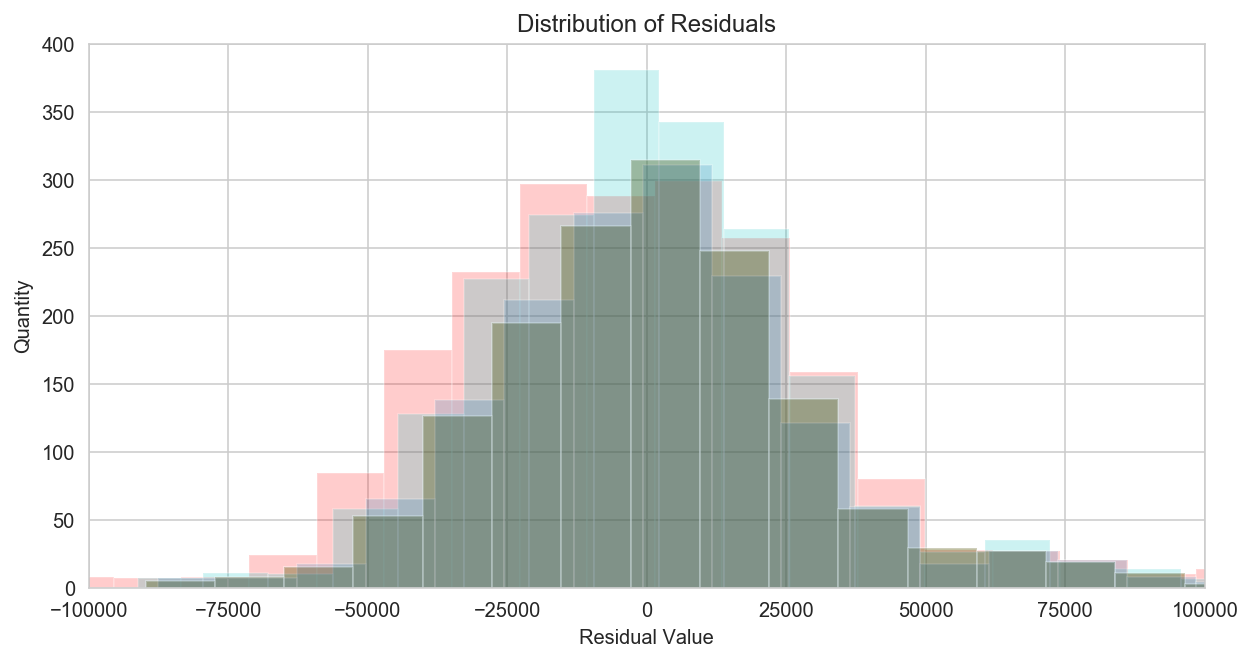

In [31]:
plt.figure(figsize = (10,5))
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Quantity')
plt.hist(resids1, bins =40, color='r', alpha=.2)
plt.hist(resids2, bins =40, color='y', alpha=.2)
plt.hist(resids3, bins =40, color='c', alpha=.2)
plt.hist(resids4, bins =40, alpha=.2)
plt.hist(resids5, bins =40, color='black', alpha=.2)
plt.xlim(-100000,100000)
;

## Inputs = ALL THE VARIABLES!<a name="set2">
6. No change to any variable
7. Log y, input variables not modified. --> Submission 6
8. Data from 7, Ridge Regression
9. Data from 7, Lasso Regression --> Submission 7
(Submissions 8 and 9 are above models with modifications to input varaibles based on weighting from Lasso Regression)
    
    
[back to top](#top)

In [32]:
X6 = h_df.drop('saleprice', axis=1)
y6 = h_df['saleprice']

X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, random_state = 42)

lr6 = LinearRegression()
lr6.fit(X6_train, y6_train)

print(f'Train R2 - {lr6.score(X6_train, y6_train)}')
print(f'Test R2 - {lr6.score(X6_test, y6_test)}')
print(f'Cross Val Score - {cross_val_score(lr6, X6_train, y6_train, cv=5).mean()}')

y_pred6 = lr6.predict(X6_train)
resids6 = y6_train-y_pred6

Train R2 - 0.8816674553042411
Test R2 - 0.8836006795335313
Cross Val Score - 0.873423087537124


In [33]:
# plt.figure(figsize = (10,10))

# plt.scatter(y_pred6, y6, c='grey', s = 3)
# plt.xlabel('Predicted Price')
# plt.title('Actual Values vs Predicted Values')
# plt.ylabel('Actual Price');

In [34]:
# plt.figure(figsize = (10,10))

# plt.scatter(y6, resids6, color = 'black', s=1)
# plt.axhline(0, c = 'red')
# plt.title('Residuals Plot')
# plt.xlabel('Home Value')
# plt.ylabel('Residuals');

In [35]:
X7 = h_df.drop('saleprice', axis=1)
y7 = np.log(h_df['saleprice'])

X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, random_state = 42)

lr7 = LinearRegression()
lr7.fit(X7_train, y7_train)

print(f'Train R2 - {lr7.score(X7_train, y7_train)}')
print(f'Test R2 - {lr7.score(X7_test, y7_test)}')
print(f'Cross Val Score - {cross_val_score(lr7, X7_train, y7_train, cv=5).mean()}')

y_pred7 = lr7.predict(X7_train)
resids7 = np.exp(y7_train)-np.exp(y_pred7)

Train R2 - 0.8896730762739359
Test R2 - 0.8497281095734743
Cross Val Score - 0.8820935532969083


In [36]:
y_kaggle_pred7 = np.exp(lr7.predict(kaggle_df.drop(['Id','Unnamed: 0'], axis=1)))
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=y_kaggle_pred7, columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_6.csv')

In [37]:
# plt.figure(figsize = (10,10))

# plt.scatter(np.exp(y_pred7), np.exp(y7), c='grey', s = 3)
# plt.xlabel('Predicted Price')
# plt.title('Actual Values vs Predicted Values')
# plt.ylabel('Actual Price');

In [38]:
# plt.figure(figsize = (10,10))

# plt.scatter(np.exp(y7), resids7, color = 'black', s=1)
# plt.axhline(0, c = 'red')
# plt.title('Residuals Plot')
# plt.xlabel('Home Value')
# plt.ylabel('Residuals');

In [39]:
X8 = h_df.drop('saleprice', axis=1)
y8 = np.log(h_df['saleprice'])

X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, random_state = 42)

ss = StandardScaler()
ss.fit(X8_train)
X8_train_sc = ss.transform(X8_train)
X8_test_sc = ss.transform(X8_test)

lr8 = LinearRegression()

ridge8 = RidgeCV()
ridge8.fit(X8_train_sc, y8_train);


y_pred8 = ridge8.predict(X8_train_sc)
y_pred_test8 = ridge8.predict(X8_test_sc)

print(f'Train R2 - {r2_score(y8_train, y_pred8)}')
print(f'Test R2 - {r2_score(y8_test, y_pred_test8)}')
print(f'Cross Val Score - {cross_val_score(ridge8, X8_train_sc, y8_train, cv=5).mean()}')

resids8 = np.exp(y8_train)-np.exp(y_pred8)

Train R2 - 0.8896689882146225
Test R2 - 0.8501251000463907
Cross Val Score - 0.8812829790932414


In [40]:
X9 = h_df.drop('saleprice', axis=1)
y9 = np.log(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1)

X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, random_state = 42)

ss = StandardScaler()
ss.fit(X9_train)
X9_train_sc = ss.transform(X9_train)
X9_test_sc = ss.transform(X9_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-4, -3, 1000)
lasso_model9 = LassoCV(alphas=l_alphas, cv=5)
lasso_model9 = lasso_model9.fit(X9_train_sc, y9_train)

lasso_model9.alpha_

y_pred9 = lasso_model9.predict(X9_train_sc)
y_pred_test9 = lasso_model9.predict(X9_test_sc)

print(f'Train R2 - {r2_score(np.exp(y9_train), np.exp(y_pred9))}')
print(f'Test R2 - {r2_score(np.exp(y9_test), np.exp(y_pred_test9))}')
print(f'Cross Val Score - {cross_val_score(lasso_model9, X9_train_sc, y9_train, cv=5).mean()}')

resids9 = np.exp(y9_train) - np.exp(y_pred9)

Train R2 - 0.9023530431359457
Test R2 - 0.9022144097992979
Cross Val Score - 0.8817422012862327


In [41]:
y_kaggle_pred9 = np.exp(lasso_model9.predict(X_kaggle_sc))
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=y_kaggle_pred9, columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_7.csv')

In [42]:
# Ran with y as a sqrt instead of log for submission 26

In [43]:
coef9 = pd.DataFrame()
coef9['columns'] = X9.columns
coef9['coefs'] = lasso_model9.coef_

In [44]:
coef9.sort_values('coefs')

,columns,coefs
9,full_bath,-0.015943
24,briardale,-0.010936
20,banked,-0.002262
4,mas_vnr_area,0.000149
15,offsite_feature,0.004029
22,northridge,0.004794
3,roof_matl,0.005764
21,culdesac,0.008072
13,has_basement,0.008388
2,roof_style,0.010077


''

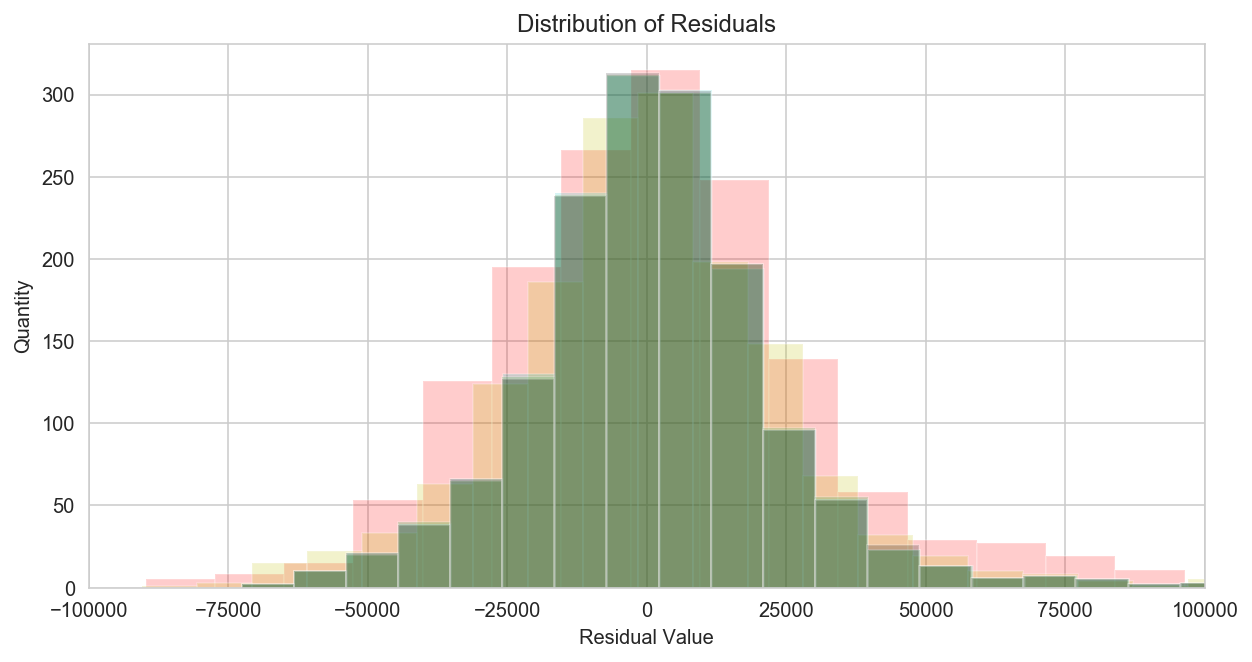

In [45]:
plt.figure(figsize = (10,5))
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Quantity')
plt.hist(resids2, bins =40, color='r', alpha=.2)
plt.hist(resids6, bins =40, color='y', alpha=.2)
plt.hist(resids7, bins =40, color='c', alpha=.2)
plt.hist(resids8, bins =40, color='g', alpha=.2)
plt.hist(resids9, bins =40, color='black', alpha=.2)
plt.xlim(-100000,100000)
;

## Reducing Inputs, looking at residual scatter plots for patterns<a name="set3">
10. MLR - Output = log y, Input variables = 'residential_low', 'residential_other', 'overall_qual', 'log_gr_liv_area', 'total_bsmt_sf', 'floating_village', 'year_built', 'kitchen_qual
11. MLR - Using scatterplots from Model 10, switched log_gr_liv_area to sq_gr_liv_area. Also changed  total_bsmt_sf to log_total_bsmt_sf. (No visible need for manipulating other variables in this data set. 
12. Used manipulations from dataset 11; Added additional variables - 'garage_area', 'bsmt_exposure', 'exter_cond', 'paved_drive', 'northridge_hts', 'attached_garage', 'full_bath', 'hillside', 'roof_style'
13. Utilized Data from model 12 as Ridge regression
14. Utilized Data from model 12 as Lasso regression --> Submission 10
    
[back to top](#top)

In [46]:
features10 = ['residential_low', 'residential_other', 
              'overall_qual', 'log_gr_liv_area', 'total_bsmt_sf',
              'floating_village', 'year_built', 'kitchen_qual']
X10 = h_df[features10]
y10 = np.log(h_df['saleprice'])

# Not splitting for this example because this is exploratory
# and variance issues are of less concern
# X10_train, X10_test, y10_train, y_test = train_test_split(X7, y7, random_state = 42)


lr10 = LinearRegression()
lr10.fit(X10, y10)

print(f'Train R2 - {lr10.score(X10, y10)}')
print(f'Cross Val Score - {cross_val_score(lr10, X10, y10, cv=5).mean()}')

y_pred10 = lr10.predict(X10)
resids10 = np.exp(y10)-np.exp(y10)

Train R2 - 0.8553285514965094
Cross Val Score - 0.8513308813711525


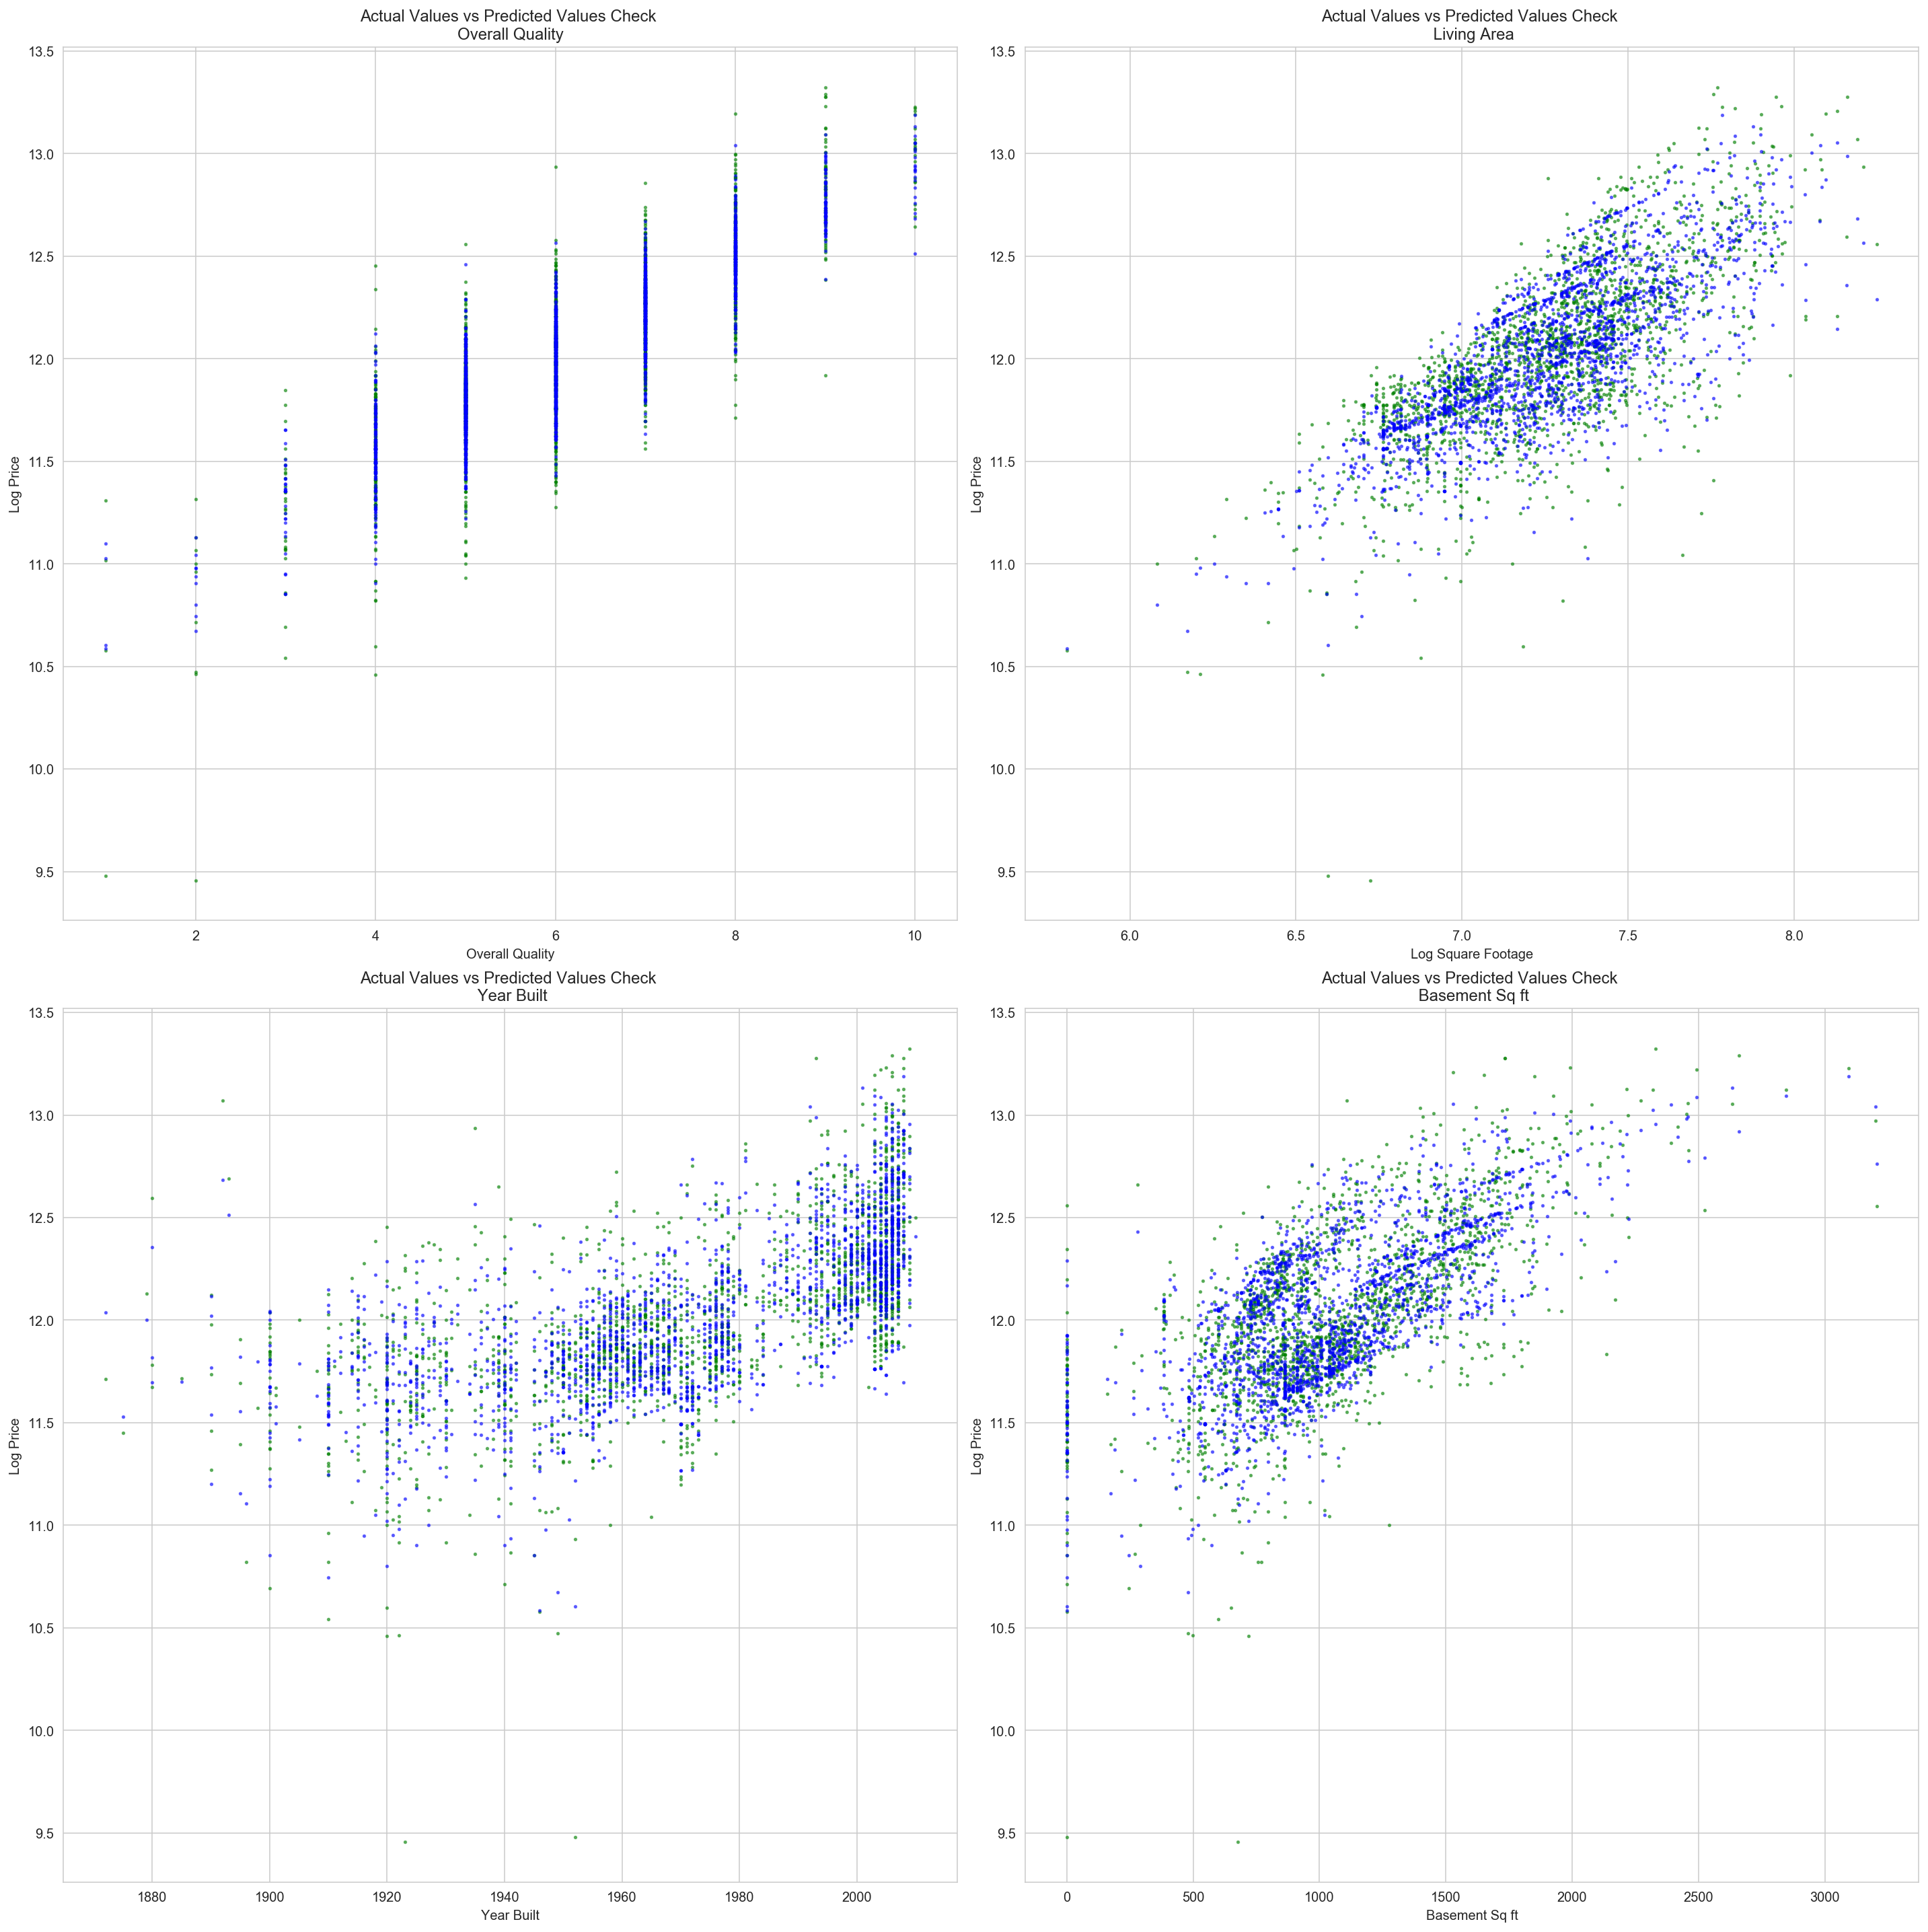

In [47]:
# Looking for patterns in scatter plots

plt.figure(figsize = (20,20))
plt.subplot(2, 2, 1)
plt.scatter(h_df.overall_qual, y10, c='green', s = 3, alpha=0.5)
plt.scatter(h_df.overall_qual, y_pred10, c='blue', s=3, alpha=0.5)
plt.xlabel('Overall Quality')
plt.ylabel('Log Price')
plt.title('Actual Values vs Predicted Values Check \nOverall Quality')

plt.subplot(2, 2, 2)
plt.scatter(h_df.log_gr_liv_area, y10, c='green', s = 3, alpha=0.5)
plt.scatter(h_df.log_gr_liv_area, y_pred10, c='blue', s=3, alpha=0.5)
plt.xlabel('Log Square Footage')
plt.ylabel('Log Price')
plt.title('Actual Values vs Predicted Values Check \n Living Area')
plt.tight_layout();

plt.subplot(2, 2, 3)
plt.scatter(h_df.year_built, y10, c='green', s = 3, alpha=0.5)
plt.scatter(h_df.year_built, y_pred10, c='blue', s=3, alpha=0.5)
plt.xlabel('Year Built')
plt.ylabel('Log Price')
plt.title('Actual Values vs Predicted Values Check \n Year Built')

plt.subplot(2, 2, 4)
plt.scatter(h_df.total_bsmt_sf, y10, c='green', s = 3, alpha=0.5)
plt.scatter(h_df.total_bsmt_sf, y_pred10, c='blue', s=3, alpha=0.5)
plt.xlabel('Basement Sq ft')
plt.ylabel('Log Price')
plt.title('Actual Values vs Predicted Values Check \n Basement Sq ft')
plt.tight_layout();

# appears that basement sq ft data should be sqrt or log
# log for square footage seems not 

In [48]:
# Basement Square Feet appears like it needs to be a square root function

h_df['log_total_bsmt_sf'] = np.log(h_df['total_bsmt_sf']+.01)
kaggle_df['log_total_bsmt_sf'] = np.log(kaggle_df['total_bsmt_sf']+.01)

h_df['sqrt_gr_liv_area'] = h_df['gr_liv_area']**0.5
kaggle_df['sqrt_gr_liv_area'] = kaggle_df['gr_liv_area']**0.5

In [49]:
features11 = ['residential_low', 'residential_other', 'log_total_bsmt_sf',
              'overall_qual', 'sqrt_gr_liv_area', 'total_bsmt_sf',
              'floating_village', 'year_built', 'kitchen_qual', 'gr_liv_area']
X11 = h_df[features11]
y11 = np.log(h_df['saleprice'])

# Not splitting for this example because this is exploratory
# and variance issues are of less concern
# X10_train, X10_test, y10_train, y_test = train_test_split(X7, y7, random_state = 42)


lr11 = LinearRegression()
lr11.fit(X11, y11)

print(f'Train R2 - {lr11.score(X11, y11)}')
print(f'Cross Val Score - {cross_val_score(lr11, X11, y11, cv=5).mean()}')

y_pred11 = lr11.predict(X11)
resids11 = np.exp(y11)-np.exp(y11)

Train R2 - 0.8572567376094227
Cross Val Score - 0.852674302483768


In [50]:
# plt.figure(figsize = (20,20))
# plt.subplot(2, 2, 1)
# plt.scatter(h_df.kitchen_qual, y11, c='green', s = 3, alpha=0.5)
# plt.scatter(h_df.kitchen_qual, y_pred11, c='blue', s=3, alpha=0.5)
# plt.xlabel('kitchen_qual')
# plt.ylabel('Log Price')
# plt.title('Actual Values vs Predicted Values Check \nkitchen_qual')

# plt.subplot(2, 2, 2)
# plt.scatter(h_df.sqrt_gr_liv_area, y11, c='green', s = 3, alpha=0.5)
# plt.scatter(h_df.sqrt_gr_liv_area, y_pred11, c='blue', s=3, alpha=0.5)
# plt.xlabel('Square Footage')
# plt.ylabel('Log Price')
# plt.title('Actual Values vs Predicted Values Check \n Living Area')
# plt.tight_layout();

# plt.subplot(2, 2, 3)
# plt.scatter(h_df.year_built, y11, c='green', s = 3, alpha=0.5)
# plt.scatter(h_df.year_built, y_pred11, c='blue', s=3, alpha=0.5)
# plt.xlabel('Year Built')
# plt.ylabel('Log Price')
# plt.title('Actual Values vs Predicted Values Check \n Year Built')

# plt.subplot(2, 2, 4)
# plt.scatter(h_df.log_total_bsmt_sf, y11, c='green', s = 3, alpha=0.5)
# plt.scatter(h_df.log_total_bsmt_sf, y_pred11, c='blue', s=3, alpha=0.5)
# plt.xlabel('log basement Sq ft')
# plt.ylabel('Log Price')
# plt.title('Actual Values vs Predicted Values Check \n Basement Sq ft')
# plt.xlim(6,8.5)
# plt.tight_layout();

In [51]:
features12 = ['residential_low', 'residential_other', 'log_total_bsmt_sf',
              'overall_qual', 'sqrt_gr_liv_area', 'total_bsmt_sf',
              'floating_village', 'year_built', 'kitchen_qual', 'gr_liv_area',
              'garage_area', 'bsmt_exposure', 'exter_cond', 'paved_drive',
              'northridge_hts', 'attached_garage', 'full_bath', 'hillside', 'roof_style'
             ]
X12 = h_df[features12]
y12 = np.log(h_df['saleprice'])

# Not splitting for this example because this is exploratory
# and variance issues are of less concern
# X10_train, X10_test, y10_train, y_test = train_test_split(X7, y7, random_state = 42)


lr12 = LinearRegression()
lr12.fit(X12, y12)

print(f'Train R2 - {lr12.score(X12, y12)}')
print(f'Cross Val Score - {cross_val_score(lr12, X12, y12, cv=5).mean()}')

y_pred12 = lr12.predict(X12)
resids12 = np.exp(y12)-np.exp(y12)

Train R2 - 0.8793057646143526
Cross Val Score - 0.8732562069133012


In [52]:
X13 = h_df[features12]
y13 = np.log(h_df['saleprice'])

X13_train, X13_test, y13_train, y13_test = train_test_split(X13, y13, random_state = 42)

ss = StandardScaler()
ss.fit(X13_train)
X13_train_sc = ss.transform(X13_train)
X13_test_sc = ss.transform(X13_test)

ridge13 = RidgeCV()
ridge13.fit(X13_train_sc, y13_train);


y_pred13 = ridge13.predict(X13_train_sc)
y_pred_test13 = ridge13.predict(X13_test_sc)

print(f'Train R2 - {r2_score(y13_train, y_pred13)}')
print(f'Test R2 - {r2_score(y13_test, y_pred_test13)}')
print(f'Cross Val Score - {cross_val_score(ridge13, X13_train_sc, y13_train, cv=5).mean()}')

resids13 = np.exp(y13_train)-np.exp(y_pred13)

Train R2 - 0.8880817711913721
Test R2 - 0.8490633676080136
Cross Val Score - 0.8806094667287949


In [55]:
X14 = h_df[features12]
y14 = np.log(h_df['saleprice'])
X_kaggle = kaggle_df[features12]

X14_train, X14_test, y14_train, y14_test = train_test_split(X14, y14, random_state = 12, test_size=0.1)

ss = StandardScaler()
ss.fit(X14_train)
X14_train_sc = ss.transform(X14_train)
X14_test_sc = ss.transform(X14_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-4, -3, 1000)
lasso_model14 = LassoCV(alphas=l_alphas, cv=5)
lasso_model14 = lasso_model14.fit(X14_train_sc, y14_train)

print (lasso_model14.alpha_)

y_pred14 = lasso_model14.predict(X14_train_sc)
y_pred_test14 = lasso_model14.predict(X14_test_sc)
y_kaggle = lasso_model14.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.exp(y14_train), np.exp(y_pred14))}')
print(f'Test R2 - {r2_score(np.exp(y14_test), np.exp(y_pred_test14))}')
print(f'Cross Val Score - {cross_val_score(lasso_model14, X14_train_sc, y14_train, cv=5).mean()}')

resids14 = np.exp(y14_train) - np.exp(y_pred14)

0.0009224970052592174
Train R2 - 0.9009510402011442
Test R2 - 0.9052940014183373
Cross Val Score - 0.8694276179313327


In [57]:
X14 = h_df[features12]
y14 = np.sqrt(h_df['saleprice'])
X_kaggle = kaggle_df[features12]

X14_train, X14_test, y14_train, y14_test = train_test_split(X14, y14, random_state = 12, test_size=0.1)

ss = StandardScaler()
ss.fit(X14_train)
X14_train_sc = ss.transform(X14_train)
X14_test_sc = ss.transform(X14_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-4, 0, 1000)
lasso_model14 = LassoCV(alphas=l_alphas, cv=5)
lasso_model14 = lasso_model14.fit(X14_train_sc, y14_train)

print (lasso_model14.alpha_)

y_pred14 = lasso_model14.predict(X14_train_sc)
y_pred_test14 = lasso_model14.predict(X14_test_sc)
y_kaggle = lasso_model14.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.square(y14_train), np.square(y_pred14))}')
print(f'Test R2 - {r2_score(np.square(y14_test), np.square(y_pred_test14))}')
print(f'Cross Val Score - {cross_val_score(lasso_model14, X14_train_sc, y14_train, cv=5).mean()}')

resids14 = np.square(y14_train) - np.square(y_pred14)

0.023462288481422625
Train R2 - 0.8962688465248398
Test R2 - 0.8951089042904946
Cross Val Score - 0.887710581408394


In [58]:
# Reran with sqrt y for submission 27

In [59]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.square(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_27.csv')

In [60]:
coef14 = pd.DataFrame()
coef14['columns'] = X14.columns
coef14['coefs'] = lasso_model14.coef_
coef14.sort_values('coefs')

,columns,coefs
4,sqrt_gr_liv_area,-21.005438
16,full_bath,-3.670673
2,log_total_bsmt_sf,-1.769798
13,paved_drive,1.465836
1,residential_other,2.184514
18,roof_style,2.314886
17,hillside,3.651269
12,exter_cond,3.741676
15,attached_garage,4.094043
14,northridge_hts,5.161695


## Feature Engineering and Variable Changes<a name="set4">
15. Iterated through various interactions, ran LASSO regressions. I kept the interaction variables that weren't given alpha values to effective. Interactions added: overall_qual*residential_low, overall_qual*floating_village, sqrt_gr_liv_area*floating_village --> Submission 11
16. Used additional values from model 15, but cycled through adding and removing low coefficient variables to improve various indicators of performance. --> Submissions 12-15
17. Used best performance from model 16 and pulled in data previously dropped from original dataset: Fireplaces, Street type Gravel, Zoning type Commercial, Lot types IR2 and Regular -- Submission 16
    
[back to top](#top)

In [62]:
# h_df['inter_qual_sqrtgr'] = h_df['overall_qual'] * h_df['sqrt_gr_liv_area']
h_df['inter_qual_rl'] = h_df['overall_qual'] * h_df['residential_low']
h_df['inter_qual_fv'] = h_df['overall_qual'] * h_df['floating_village']
h_df['inter_area_fv'] = h_df['sqrt_gr_liv_area'] * h_df['floating_village']
kaggle_df['inter_qual_rl'] = kaggle_df['overall_qual'] * kaggle_df['residential_low']
kaggle_df['inter_qual_fv'] = kaggle_df['overall_qual'] * kaggle_df['floating_village']
kaggle_df['inter_area_fv'] = kaggle_df['sqrt_gr_liv_area'] * kaggle_df['floating_village']
# h_df['inter_area_rl'] = h_df['sqrt_gr_liv_area'] * h_df['residential_low']
# h_df['inter_quals'] = h_df['overall_qual'] * h_df['kitchen_qual']
# h_df['inter_year_fv'] = h_df['year_built'] * h_df['floating_village']
# h_df['inter_year_area'] = h_df['year_built'] * h_df['sqrt_gr_liv_area']
# h_df.drop(['inter_area_rl', 'inter_quals', 'inter_year_fv', 'inter_year_area'], axis=1, inplace =True)

In [64]:
features15 = ['residential_low', 'residential_other',
              'overall_qual', 'sqrt_gr_liv_area', 'total_bsmt_sf',
              'floating_village', 'year_built', 'kitchen_qual',
              'garage_area', 'bsmt_exposure', 'exter_cond', 'paved_drive',
              'northridge_hts', 'attached_garage', 'full_bath', 'hillside',
              'inter_qual_rl', 'inter_qual_fv', 'inter_area_fv',
             ]
X15 = h_df[features15]
y15 = np.log(h_df['saleprice'])
X_kaggle = kaggle_df[features15]

X15_train, X15_test, y15_train, y15_test = train_test_split(X15, y15, random_state = 12, test_size=0.1)

ss = StandardScaler()
ss.fit(X15_train)
X15_train_sc = ss.transform(X15_train)
X15_test_sc = ss.transform(X15_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-4, -2, 1000)
lasso_model15 = LassoCV(alphas=l_alphas, cv=5)
lasso_model15 = lasso_model15.fit(X15_train_sc, y15_train)

print (lasso_model15.alpha_)

y_pred15 = lasso_model15.predict(X15_train_sc)
y_pred_test15 = lasso_model15.predict(X15_test_sc)
y_kaggle = lasso_model15.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.exp(y15_train), np.exp(y_pred15))}')
print(f'Test R2 - {r2_score(np.exp(y15_test), np.exp(y_pred_test15))}')
print(f'Cross Val Score - {cross_val_score(lasso_model15, X15_train_sc, y15_train, cv=5).mean()}')

resids15 = np.exp(y15_train) - np.exp(y_pred15)

0.00010046204213468131
Train R2 - 0.9013125080099045
Test R2 - 0.9033038178739909
Cross Val Score - 0.8708740029847141


In [65]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.exp(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_11.csv')

In [66]:
coef15 = pd.DataFrame()
coef15['columns'] = X15.columns
coef15['coefs'] = lasso_model15.coef_
coef15.sort_values('coefs')

,columns,coefs
16,inter_qual_rl,-0.090290
17,inter_qual_fv,-0.064877
14,full_bath,-0.016016
5,floating_village,0.011309
12,northridge_hts,0.012946
15,hillside,0.013175
11,paved_drive,0.017164
13,attached_garage,0.022461
10,exter_cond,0.026398
9,bsmt_exposure,0.028695


In [68]:
X16 = h_df.drop('saleprice', axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'mas_vnr_area', 'roof_style',
     'has_basement'], axis=1)
y16 = np.log(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 
     'has_basement'], axis=1)

X16_train, X16_test, y16_train, y16_test = train_test_split(X16, y16, random_state = 12, test_size=0.01)

ss = StandardScaler()
ss.fit(X16_train)
X16_train_sc = ss.transform(X16_train)
X16_test_sc = ss.transform(X16_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-15, -12, 1000)
lasso_model16 = LassoCV(alphas=l_alphas, cv=5)
lasso_model16 = lasso_model16.fit(X16_train_sc, y16_train)

print (lasso_model16.alpha_)

y_pred16 = lasso_model16.predict(X16_train_sc)
y_pred_test16 = lasso_model16.predict(X16_test_sc)
y_kaggle = lasso_model16.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.square(y16_train), np.square(y_pred16))}')
print(f'Test R2 - {r2_score(np.square(y16_test), np.square(y_pred_test16))}')
print(f'Cross Val Score - {cross_val_score(lasso_model16, X16_train_sc, y16_train, cv=5).mean()}')

resids16 = np.exp(y16_train) - np.exp(y_pred16)

1.1805165285688031e-15
Train R2 - 0.8876078323832842
Test R2 - 0.8297184950977775
Cross Val Score - 0.8771410538009545


In [69]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.exp(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_15.csv')

In [70]:
# ran with y as sqrt instead of log to create submissions 22 and 23

In [71]:
coef16 = pd.DataFrame()
coef16['columns'] = X16.columns
coef16['coefs'] = lasso_model16.coef_
coef16.sort_values('coefs')

,columns,coefs
23,inter_qual_rl,-0.106340
24,inter_qual_fv,-0.085332
7,full_bath,-0.014299
21,briardale,-0.010487
17,banked,-0.001131
2,roof_matl,0.002398
12,offsite_feature,0.007293
19,northridge,0.008291
18,culdesac,0.010430
16,hillside,0.014536


In [72]:
old_train = pd.read_csv('./datasets/train.csv')

In [73]:
old_test = pd.read_csv('./datasets/test.csv')

In [74]:
h_df['fireplaces'] = old_train['Fireplaces']
kaggle_df['fireplaces'] = old_test['Fireplaces']

In [75]:
h_df['str_gravel'] = old_train['Street'].map({'Grvl' : 1})
h_df['str_gravel'][h_df['str_gravel'].isnull()] = 0

kaggle_df['str_gravel'] = old_test['Street'].map({'Grvl' : 1})
kaggle_df['str_gravel'][kaggle_df['str_gravel'].isnull()] = 0

In [76]:
h_df['commercial'] = old_train['MS Zoning'].map({'C (all)' : 1})
h_df['commercial'][h_df['commercial'].isnull()] = 0

kaggle_df['commercial'] = old_test['MS Zoning'].map({'C (all)' : 1})
kaggle_df['commercial'][kaggle_df['commercial'].isnull()] = 0

In [77]:
h_df['regular_lot'] = old_train['Lot Shape'].map({'Reg' : 1})
h_df['regular_lot'][h_df['regular_lot'].isnull()] = 0

h_df['ir2_lot'] = old_train['Lot Shape'].map({'IR2' : 1})
h_df['ir2_lot'][h_df['ir2_lot'].isnull()] = 0

kaggle_df['regular_lot'] = old_test['Lot Shape'].map({'Reg' : 1})
kaggle_df['regular_lot'][kaggle_df['regular_lot'].isnull()] = 0

kaggle_df['ir2_lot'] = old_test['Lot Shape'].map({'IR2' : 1})
kaggle_df['ir2_lot'][kaggle_df['ir2_lot'].isnull()] = 0

In [121]:
X17 = h_df.drop('saleprice', axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 'has_basement',
     'banked', 'roof_matl', 'briardale'], axis=1)
y17 = np.log(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 'has_basement',
     'banked', 'roof_matl', 'briardale'], axis=1)

X17_train, X17_test, y17_train, y17_test = train_test_split(X17, y17, random_state = 12, test_size=0.01)

ss = StandardScaler()
ss.fit(X17_train)
X17_train_sc = ss.transform(X17_train)
X17_test_sc = ss.transform(X17_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-15, -12, 1000)
lasso_model17 = LassoCV(alphas=l_alphas, cv=5)
lasso_model17 = lasso_model17.fit(X17_train_sc, y17_train)

print (lasso_model17.alpha_)

y_pred17 = lasso_model17.predict(X17_train_sc)
y_pred_test17 = lasso_model17.predict(X17_test_sc)
y_kaggle = lasso_model17.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.exp(y17_train), np.exp(y_pred17))}')
print(f'Test R2 - {r2_score(np.exp(y17_test), np.exp(y_pred_test17))}')
print(f'Cross Val Score - {cross_val_score(lasso_model17, X17_train_sc, y17_train, cv=5).mean()}')

resids17 = y17_train - y_pred17

1e-12
Train R2 - 0.9041249390134027
Test R2 - 0.8941277596168131
Cross Val Score - 0.8772585171401464


In [ ]:
# Reran test 17 with no change except taking the sqrt of y rather than the log of y

In [80]:
X17 = h_df.drop('saleprice', axis=1).drop(
    ['log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 'has_basement',
     'banked', 'roof_matl', 'briardale'], axis=1)
y17 = np.sqrt(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
    ['log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 'has_basement',
     'banked', 'roof_matl', 'briardale'], axis=1)

X17_train, X17_test, y17_train, y17_test = train_test_split(X17, y17, random_state = 12, test_size=0.01)

ss = StandardScaler()
ss.fit(X17_train)
X17_train_sc = ss.transform(X17_train)
X17_test_sc = ss.transform(X17_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-15, -12, 1000)
lasso_model17 = LassoCV(alphas=l_alphas, cv=5)
lasso_model17 = lasso_model17.fit(X17_train_sc, y17_train)

print (lasso_model17.alpha_)

y_pred17 = lasso_model17.predict(X17_train_sc)
y_pred_test17 = lasso_model17.predict(X17_test_sc)
y_kaggle = lasso_model17.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.square(y17_train), np.square(y_pred17))}')
print(f'Test R2 - {r2_score(np.square(y17_test), np.square(y_pred_test17))}')
print(f'Cross Val Score - {cross_val_score(lasso_model17, X17_train_sc, y17_train, cv=5).mean()}')

resids17 = y17_train - y_pred17

1e-12
Train R2 - 0.8982101929119835
Test R2 - 0.8262068672992602
Cross Val Score - 0.8919343238622552


In [123]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.exp(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_28.csv')

In [ ]:
# reran for submissions 24 and 25

In [82]:
coef17 = pd.DataFrame()
coef17['columns'] = X17.columns
coef17['coefs'] = lasso_model17.coef_
coef17.sort_values('coefs')

,columns,coefs
19,log_gr_liv_area,-12.986911
14,floating_village,-9.983305
22,inter_qual_fv,-3.270033
20,sqrt_gr_liv_area,-3.067734
6,full_bath,-2.748225
27,regular_lot,-0.286179
21,inter_qual_rl,-0.231728
25,str_gravel,-0.085745
26,commercial,0.559555
28,ir2_lot,1.170062


In [83]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.exp(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_16.csv')

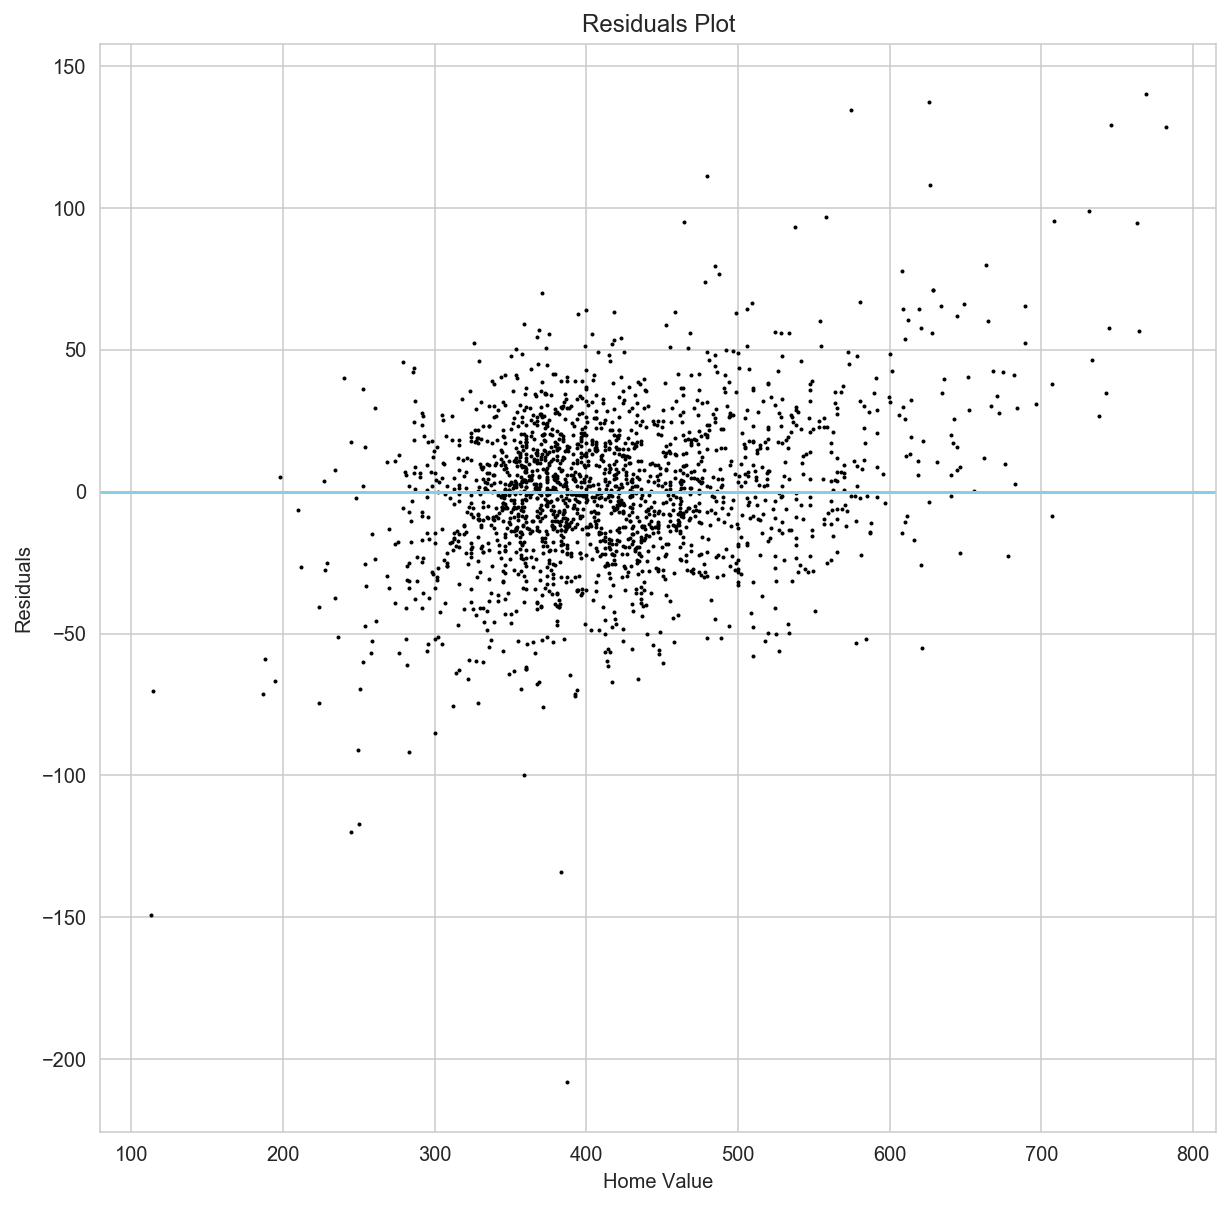

In [84]:
plt.figure(figsize = (10,10))

plt.scatter(y17_train, resids17, color = 'black', s=1)
plt.axhline(0, c = 'skyblue')
plt.title('Residuals Plot')
plt.xlabel('Home Value')
plt.ylabel('Residuals');

## Polynomial Fit <a name="set5">
18. LASSO poly fit on highest impact variables 
19. Added in: overall quality squared and overall quality X basement, ran lasso from 17
    
[back to top](#top)

In [85]:
features18 = ['residential_low', 'overall_qual', 'gr_liv_area', 'total_bsmt_sf', 
           'floating_village']
X18 = h_df[features18]
y18 = np.log(h_df['saleprice'])
# X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
#     ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 'has_basement',
#      'banked', 'sq_total_bsmt_sf', 'roof_matl', 'briardale'], axis=1)

poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X18)

X18_train, X18_test, y18_train, y18_test = train_test_split(X_poly, y18, random_state = 12, test_size=0.2)

ss = StandardScaler()
ss.fit(X18_train)
X18_train_sc = ss.transform(X18_train)
X18_test_sc = ss.transform(X18_test)
# X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-15, -12, 1000)
lasso_model18 = LassoCV(alphas=l_alphas, cv=5)
lasso_model18 = lasso_model18.fit(X18_train_sc, y18_train)

print (lasso_model18.alpha_)

y_pred18 = lasso_model18.predict(X18_train_sc)
y_pred_test18 = lasso_model18.predict(X18_test_sc)
# y_kaggle = lasso_model17.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.exp(y18_train), np.exp(y_pred18))}')
print(f'Test R2 - {r2_score(np.exp(y18_test), np.exp(y_pred_test18))}')
print(f'Cross Val Score - {cross_val_score(lasso_model18, X18_train_sc, y18_train, cv=5).mean()}')

resids18 = y18_train - y_pred18

9.86265846131283e-13
Train R2 - 0.871044133502699
Test R2 - 0.8606165945463861
Cross Val Score - 0.8301024073618082


In [86]:
coef18 = pd.DataFrame()
coef18['columns'] = poly.get_feature_names(features18)
coef18['coefs'] = lasso_model18.coef_
coef18.sort_values('coefs')

,columns,coefs
10,overall_qual^2,-0.175234
13,overall_qual floating_village,-0.128368
6,residential_low overall_qual,-0.117610
15,gr_liv_area total_bsmt_sf,-0.099085
8,residential_low total_bsmt_sf,-0.061736
14,gr_liv_area^2,-0.055747
5,residential_low^2,-0.043980
18,total_bsmt_sf floating_village,-0.021911
17,total_bsmt_sf^2,-0.014577
9,residential_low floating_village,0.000000


In [87]:
# only interaction variables worth adding based on coefficients below: 
h_df['qual_bsmt_sf'] = h_df['overall_qual']*h_df['total_bsmt_sf']
h_df['square_overall_qual'] = h_df['overall_qual']**2

kaggle_df['qual_bsmt_sf'] = kaggle_df['overall_qual']*kaggle_df['total_bsmt_sf']
kaggle_df['square_overall_qual'] = kaggle_df['overall_qual']**2

In [114]:
X19 = h_df.drop('saleprice', axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 'has_basement',
     'banked', 'roof_matl', 'briardale'], axis=1)
y19 = np.sqrt(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'mas_vnr_area', 'roof_style', 'has_basement',
     'banked', 'roof_matl', 'briardale'], axis=1)

X19_train, X19_test, y19_train, y19_test = train_test_split(X19, y19, random_state = 12, test_size=0.05)

ss = StandardScaler()
ss.fit(X19_train)
X19_train_sc = ss.transform(X19_train)
X19_test_sc = ss.transform(X19_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-5, 0, 1000)
lasso_model19 = LassoCV(alphas=l_alphas, cv=5)
lasso_model19 = lasso_model19.fit(X19_train_sc, y19_train)

print (lasso_model19.alpha_)

y_pred19 = lasso_model19.predict(X19_train_sc)
y_pred_test19 = lasso_model19.predict(X19_test_sc)
y_kaggle = lasso_model19.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.square(y19_train), np.square(y_pred19))}')
print(f'Test R2 - {r2_score(np.square(y19_test), np.square(y_pred_test19))}')
print(f'Cross Val Score - {cross_val_score(lasso_model19, X19_train_sc, y19_train, cv=5).mean()}')

resids19 = y19_train - y_pred19

0.025906778586880088
Train R2 - 0.9033328838660715
Test R2 - 0.8990151287422266
Cross Val Score - 0.8936972583880062


In [89]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.exp(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_17.csv')

In [90]:
# coef19 = pd.DataFrame()
# coef19['columns'] = X19.columns
# coef19['coefs'] = lasso_model19.coef_
# coef19.sort_values('coefs')

In [116]:
X19 = h_df.drop('saleprice', axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 
     'mas_vnr_area', 'roof_style', 'has_basement',
     'floating_village', 'commercial', 'ir2_lot', 'str_gravel', 'regular_lot',
     'full_bath', 'inter_qual_fv', 'fireplaces', 'total_bsmt_sf',
     'offsite_feature', 'northridge', 'culdesac', 
     'banked', 'roof_matl', 'briardale'], axis=1)
y19 = np.log(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 
     'mas_vnr_area', 'roof_style', 'has_basement',
     'floating_village', 'commercial', 'ir2_lot', 'str_gravel', 'regular_lot',
     'full_bath', 'inter_qual_fv', 'fireplaces', 'total_bsmt_sf',
     'offsite_feature', 'northridge', 'culdesac', 
     'banked', 'roof_matl', 'briardale'], axis=1)

X19_train, X19_test, y19_train, y19_test = train_test_split(X19, y19, random_state = 12, test_size=0.05)

ss = StandardScaler()
ss.fit(X19_train)
X19_train_sc = ss.transform(X19_train)
X19_test_sc = ss.transform(X19_test)
X_kaggle_sc = ss.transform(X_kaggle)

l_alphas = np.logspace(-5, 0, 1000)
lasso_model19 = LassoCV(alphas=l_alphas, cv=5)
lasso_model19 = lasso_model19.fit(X19_train_sc, y19_train)

print (lasso_model19.alpha_)

y_pred19 = lasso_model19.predict(X19_train_sc)
y_pred_test19 = lasso_model19.predict(X19_test_sc)
y_kaggle = lasso_model19.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(np.exp(y19_train), np.exp(y_pred19))}')
print(f'Test R2 - {r2_score(np.exp(y19_test), np.exp(y_pred_test19))}')
print(f'Cross Val Score - {cross_val_score(lasso_model19, X19_train_sc, y19_train, cv=5).mean()}')

resids19 = y19_train - y_pred19

1.216424293857368e-05
Train R2 - 0.9004176443124671
Test R2 - 0.8913813868917704
Cross Val Score - 0.8737132808760624


In [117]:
coef19 = pd.DataFrame()
coef19['columns'] = X19.columns
coef19['coefs'] = lasso_model19.coef_
coef19.sort_values('coefs')

,columns,coefs
17,square_overall_qual,-0.162338
14,inter_qual_rl,-0.074527
12,northridge_hts,0.015601
11,hillside,0.016426
7,paved_drive,0.016889
8,attached_garage,0.021742
2,exter_cond,0.025252
3,bsmt_exposure,0.029612
6,garage_area,0.037771
1,year_built,0.039384


In [92]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.exp(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_19.csv')

In [93]:
X20 = h_df.drop('saleprice', axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'inter_qual_fv',
     'mas_vnr_area', 'roof_style', 'has_basement', 'offsite_feature',
     'floating_village', 'commercial', 'ir2_lot', 'str_gravel', 'regular_lot',
     'banked', 'roof_matl', 'briardale'], axis=1)
y20 = np.sqrt(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 'inter_qual_fv',
     'mas_vnr_area', 'roof_style', 'has_basement', 'offsite_feature',
     'floating_village', 'commercial', 'ir2_lot', 'str_gravel', 'regular_lot',
     'banked', 'roof_matl', 'briardale'], axis=1)

X20_train, X20_test, y20_train, y20_test = train_test_split(X20, y20, random_state = 12, test_size=0.05)

ss = StandardScaler()
ss.fit(X20_train)
X20_train_sc = ss.transform(X20_train)
X20_test_sc = ss.transform(X20_test)
X_kaggle_sc = ss.transform(X_kaggle)

ridge20 = RidgeCV()
ridge20.fit(X20_train_sc, y20_train);


y_pred20 = ridge20.predict(X20_train_sc)
y_pred_test20 = ridge20.predict(X20_test_sc)
y_kaggle = ridge20.predict(X_kaggle_sc)

print(f'Train R2 - {r2_score(y20_train, y_pred20)}')
print(f'Test R2 - {r2_score(y20_test, y_pred_test20)}')
print(f'Cross Val Score - {cross_val_score(ridge20, X20_train_sc, y20_train, cv=5).mean()}')

resids20 = np.square(y20_train)-np.square(y_pred20)

Train R2 - 0.8987532434037341
Test R2 - 0.9068758595876808
Cross Val Score - 0.8939678213587596


In [94]:
y_kaggle_df = pd.DataFrame(index=kaggle_df['Id'], data=np.square(y_kaggle), columns=['SalePrice'])
y_kaggle_df.to_csv('./datasets/Siboni_sub_regression_21.csv')

In [95]:
X20 = h_df.drop('saleprice', axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 
     'mas_vnr_area', 'roof_style', 'has_basement',
     'full_bath', 'inter_qual_fv', 
     'floating_village', 'commercial', 'ir2_lot', 'str_gravel', 'regular_lot',
     'banked', 'roof_matl', 'briardale'], axis=1)
y20 = np.log(h_df['saleprice'])
X_kaggle = kaggle_df.drop(['Id','Unnamed: 0'], axis=1).drop(
    ['sqrt_gr_liv_area', 'log_total_bsmt_sf', 
     'mas_vnr_area', 'roof_style', 'has_basement',
     'full_bath', 'inter_qual_fv', 
     'floating_village', 'commercial', 'ir2_lot', 'str_gravel', 'regular_lot',
     'banked', 'roof_matl', 'briardale'], axis=1)

X20_train, X20_test, y20_train, y20_test = train_test_split(X20, y20, random_state = 12, test_size=0.05)

ss = StandardScaler()
ss.fit(X20_train)
X20_train_sc = ss.transform(X20_train)
X20_test_sc = ss.transform(X20_test)

ridge20 = RidgeCV()
ridge20.fit(X20_train_sc, y20_train);


y_pred20 = ridge20.predict(X20_train_sc)
y_pred_test20 = ridge20.predict(X20_test_sc)

print(f'Train R2 - {r2_score(y20_train, y_pred20)}')
print(f'Test R2 - {r2_score(y20_test, y_pred_test20)}')
print(f'Cross Val Score - {cross_val_score(ridge20, X20_train_sc, y20_train, cv=5).mean()}')

resids20 = np.exp(y20_train)-np.exp(y_pred20)

Train R2 - 0.8815983760919798
Test R2 - 0.8917171527581557
Cross Val Score - 0.8745568453213233


In [96]:
h_df.to_csv('./datasets/train_final.csv')

In [120]:
# Input variables per feedback from Laura, Kai and Stephen
h_df['was_remodeled'] = old_train['Year Remod/Add'] == old_train['Year Built']
h_df['was_remodeled'] = h_df['was_remodeled'].map({True:1, False:0})
kaggle_df['was_remodeled'] = old_test['Year Remod/Add'] == old_test['Year Built']
kaggle_df['was_remodeled'] = kaggle_df['was_remodeled'].map({True:1, False:0})

h_df['was_recently_remodeled'] = (h_df['was_remodeled'] == 1) & (old_train['Year Remod/Add']>1990)
h_df['was_recently_remodeled'] = h_df['was_recently_remodeled'].map({True:1, False:0})
kaggle_df['was_recently_remodeled'] = (kaggle_df['was_remodeled'] == 1) & (old_test['Year Remod/Add']>1990)
kaggle_df['was_recently_remodeled'] = kaggle_df['was_recently_remodeled'].map({True:1, False:0})

h_df['age_at_sale'] = old_train['Yr Sold'] - old_train['Year Built']
kaggle_df['age_at_sale'] = old_test['Yr Sold'] - old_test['Year Built']